# Capstone Project

El trabajo consiste en el análisis del repositorio de datos "Adult" tomado de [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Adult).

El conjunto de datos trabajado en el presente notebook puede ser descargado de: [Conjunto de Datos](https://raw.githubusercontent.com/luquillas/Repositorio01/master/DatosCenso/datos/DatosCenso.csv)

El conjunto de datos consta de 48842 instancias y 14 atributos con el siguiente detalle:

* **age:** Edad. (Continuo)
* **workclass:** Tipo de trabajo. (Categórico)
* **fnlwgt:** Peso de la muestra. (Continuo)
* **education:** Nivel Educativo. (Categórico)
* **education-num:** Años de estudio. (Continuo)
* **marital-status:** Estado civil. (Categórico)
* **occupation:** Ocupación. (Categórico)
* **relationship:** Relación familiar. (Categórico)
* **race:** Etnia. (Categórico)
* **sex:** Genéro (Categórico)
* **capital-gain:** Capital ganado. (Continuo)
* **capital-loss:** Capital perdido. (Continuo)
* **hours-per-week:** Horas de trabajo por semana (Continuo)
* **native-country:** País. (Categórico)

Los datos fueron generados en el año 1994 y el objetivo es determinar si una persona gana más de $50,000.00 anuales.


## Tabla de Contenido

1. [Lectura del conjunto de datos](#Lectura)

    1.1 [Descripción del conjunto de datos](#Descripcion)
    

2. [Preprocesamiento del conjunto de datos](#Preprocesamiento)

    2.1 [Exploración inicial de datos](#Exploracion)

    2.2 [Codificación de atributos categóricos](#codificacion)

    2.3 [Eliminación Recursiva de Características](#RFE)
    
    2.3.1 [Gráfico RFE con Validación Cruzada](#RFEGrafico)
    
    2.3.2 [Atributos elegidos RFE](#RFEAtributos)

    2.4 [Gráfico de Correlación](#Correlacion)


3. [Creación de conjuntos de entrenamiento y prueba ](#Conjuntos)


4. [Eliminación de atributos con PCA](#PCA)


5. [Entrenamiento y Evaluación](#EntrenamientoEvaluacion)


6. [Entrenamiento de modelos](#Entrenamiento)

    6.1 [Método para entrenamiento](#Metodo)

    6.2 [Evaluación de los modelos](#Evaluacion)

    6.3 [Ajuste de los modelos](#Ajuste)

    6.4 [Matriz de confusión](#Matriz)


In [42]:

import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
import scipy


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.model_selection import train_test_split


from sklearn import preprocessing


from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

import time


<a id='Lectura'></a>

## Lectura del conjunto de datos e impresión de encabezado y primeras filas.

El conjunto de datos no cuenta con un encabezado por lo que es necesario nombrar cada atributo de forma manual. Cuenta con datos inválidos en los atributos ClaseTrabajo, Ocupación y Pais y los datos son indicados con un "?". Algunos datos cuentan con espacios en blanco por lo que se le aplica un "trim" para eliminar estos espacios.


In [2]:
columnas = ['Edad', 'ClaseTrabajo', 'PesoMuestra', 'NivelEducativo', 'AnosEducacion','EstadoCivil', 'Ocupacion', 'EstadoActual',
          'Etnia', 'Genero', 'CapitalGanado', 'CapitalPerdido', 'HorasSemana', 'Pais', 'Ingreso']
ClientesSinProcesar = pd.read_csv('DatosCenso.csv',header=None,names=columnas,na_values='?',sep=' *, *',engine='python')
ClientesSinProcesar.head()

,Edad,ClaseTrabajo,PesoMuestra,NivelEducativo,AnosEducacion,EstadoCivil,Ocupacion,EstadoActual,Etnia,Genero,CapitalGanado,CapitalPerdido,HorasSemana,Pais,Ingreso
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<a id='Descripcion'></a>
## Descripción del tipo de datos de cada uno de los atributos.


In [3]:
ClientesSinProcesar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
Edad              48842 non-null int64
ClaseTrabajo      46043 non-null object
PesoMuestra       48842 non-null int64
NivelEducativo    48842 non-null object
AnosEducacion     48842 non-null int64
EstadoCivil       48842 non-null object
Ocupacion         46033 non-null object
EstadoActual      48842 non-null object
Etnia             48842 non-null object
Genero            48842 non-null object
CapitalGanado     48842 non-null int64
CapitalPerdido    48842 non-null int64
HorasSemana       48842 non-null int64
Pais              47985 non-null object
Ingreso           48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


<a id='Preprocesamiento'></a>
## Preprocesamiento de los datos, entre los cambios necesarios se aplica:
* Eliminación de atributos innecesarios. 
    * **PesoMuestra:** Se considera no tiene relación con la variable dependiente.
    * **NivelEducativo.** Se considera un atributo duplicado, el atributo "AnosEducacion" aporta la misma información.
* Eliminación de datos inválidos. Se elimina un total de 3620 instancias con datos inválidos, un 7.41% del total de 48842.
* Asignación de la variable dependiente y separación de variables
* Reemplazo de valores en la variable dependiente, ya que se encuentran cuatro valores distintos: "=50K","<=50K",">50K.",">50K". Quedando de la siguiente forma: 0 para los valores menores a $50,000.00 y 1 para los valores mayores.
* Conversión del tipo de datos a categórico para los atributos que aplica.
* Aplicación de codificación para los datos categóricos

In [4]:
ClientesProcesados = ClientesSinProcesar.iloc[:,:]
ClientesProcesados.drop("PesoMuestra", axis=1, inplace=True)
ClientesProcesados.drop("NivelEducativo", axis=1, inplace=True)

In [5]:
ClientesProcesados.isna().values.any().any()
#ClientesProcesados=ClientesProcesados.fillna({'ClaseTrabajo': 'Desconocido','Ocupacion':'Desconocido','Pais':'Desconocido'})

True

In [6]:
ClientesProcesados.isna().sum()

Edad                 0
ClaseTrabajo      2799
AnosEducacion        0
EstadoCivil          0
Ocupacion         2809
EstadoActual         0
Etnia                0
Genero               0
CapitalGanado        0
CapitalPerdido       0
HorasSemana          0
Pais               857
Ingreso              0
dtype: int64

In [7]:
ClientesProcesados=ClientesProcesados.dropna()

In [8]:
ClientesProcesados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 13 columns):
Edad              45222 non-null int64
ClaseTrabajo      45222 non-null object
AnosEducacion     45222 non-null int64
EstadoCivil       45222 non-null object
Ocupacion         45222 non-null object
EstadoActual      45222 non-null object
Etnia             45222 non-null object
Genero            45222 non-null object
CapitalGanado     45222 non-null int64
CapitalPerdido    45222 non-null int64
HorasSemana       45222 non-null int64
Pais              45222 non-null object
Ingreso           45222 non-null object
dtypes: int64(5), object(8)
memory usage: 4.8+ MB


<a id='Exploracion'></a>

## Exploración inicial de datos


In [9]:
ClientesProcesados.describe()

,Edad,AnosEducacion,CapitalGanado,CapitalPerdido,HorasSemana
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024AB300DF88>,
      dtype=object)

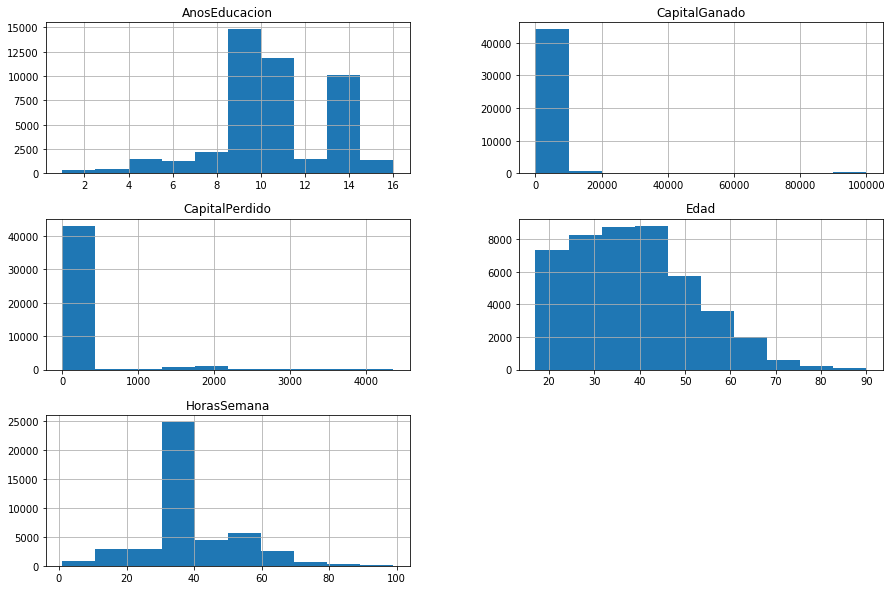

In [10]:
ClientesProcesados.hist(figsize = (15,10))

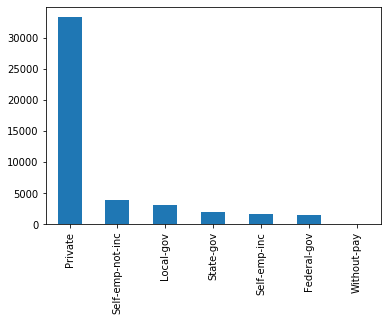

In [11]:
ClientesProcesados['ClaseTrabajo'].value_counts().plot(kind='bar')

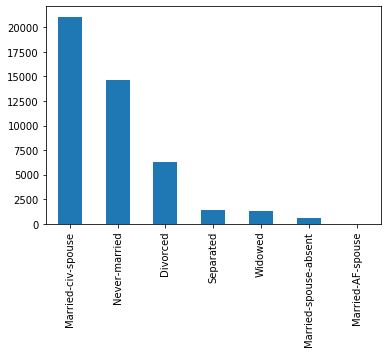

In [12]:
ClientesProcesados['EstadoCivil'].value_counts().plot(kind='bar')

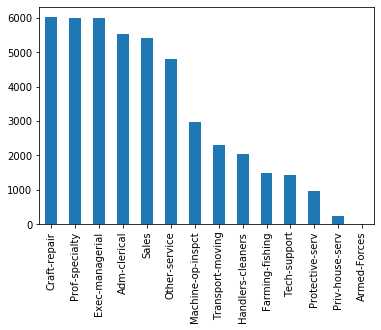

In [13]:
ClientesProcesados['Ocupacion'].value_counts().plot(kind='bar')

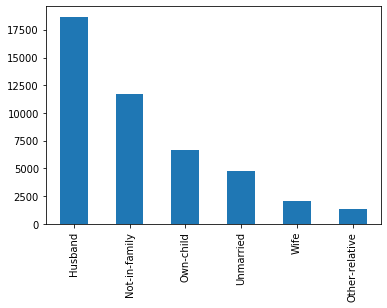

In [14]:
ClientesProcesados['EstadoActual'].value_counts().plot(kind='bar')

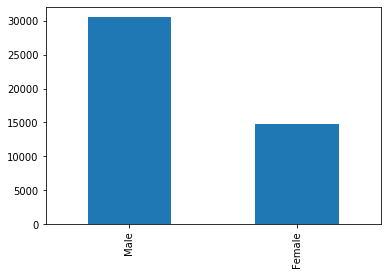

In [15]:
ClientesProcesados['Genero'].value_counts().plot(kind='bar')

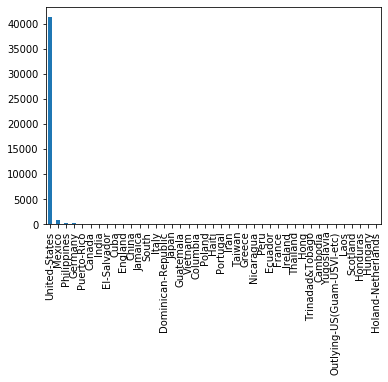

In [16]:
ClientesProcesados['Pais'].value_counts().plot(kind='bar')

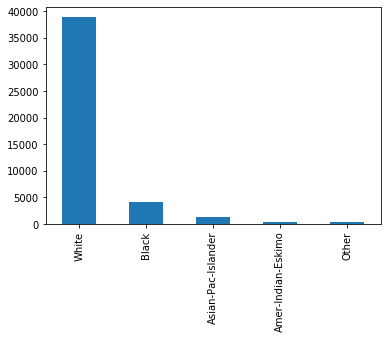

In [17]:
ClientesProcesados['Etnia'].value_counts().plot(kind='bar')

C:\Users\jorrodro\Anaconda3\lib\site-packages\pandas\core\frame.py:4263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0    34014
1    11208
Name: Ingreso, dtype: int64

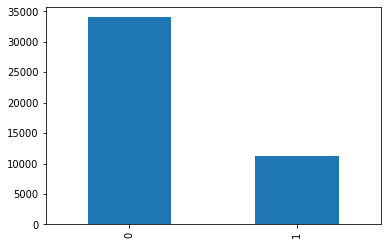

In [18]:
ClientesProcesados.replace(to_replace='<=50K.',value='0',inplace=True)
ClientesProcesados.replace(to_replace='<=50K',value='0',inplace=True)
ClientesProcesados.replace(to_replace='>50K.',value='1',inplace=True)
ClientesProcesados.replace(to_replace='>50K',value='1',inplace=True)
ClientesProcesados['Ingreso'].value_counts().plot(kind='bar')
ClientesProcesados['Ingreso'].value_counts()

<a id='codificacion'></a>
## Codificación de atributos categóricos. 

La mayoría de algoritmos de clasificación trabajan con datos numéricos y en caso de existir otro tipo de datos pueden presentar errores o cálculos incorrectos.

La codificación es aplicada para convertir datos tipo categóricos a un dato ficticio, generando por cada valor existente un nuevo atributo. Este atributo tiene dos valores solamente 0 o 1. El método coloca un 0 cuando el valor de la instancia sea diferente al atributo y 1 cuando el valor corresponde al atributo.


In [19]:

ClientesProcesados_df = pd.DataFrame(ClientesProcesados, columns=['ClaseTrabajo','EstadoCivil','Ocupacion','EstadoActual','Etnia','Genero','Pais'])

dum_df = pd.get_dummies(ClientesProcesados_df, columns=['ClaseTrabajo','EstadoCivil','Ocupacion','EstadoActual','Etnia','Genero','Pais'], 
                                                prefix=['Type_is','Type_is','Type_is','Type_is','Type_is','Type_is','Type_is'] )

ClientesProcesados_df = ClientesProcesados_df.join(dum_df)

In [20]:
ClientesProcesados_df.drop("ClaseTrabajo", axis=1, inplace=True)
ClientesProcesados_df.drop("EstadoCivil", axis=1, inplace=True)
ClientesProcesados_df.drop("Ocupacion", axis=1, inplace=True)
ClientesProcesados_df.drop("EstadoActual", axis=1, inplace=True)
ClientesProcesados_df.drop("Etnia", axis=1, inplace=True)
ClientesProcesados_df.drop("Genero", axis=1, inplace=True)
ClientesProcesados_df.drop("Pais", axis=1, inplace=True)

In [21]:
ClientesProcesados_df=ClientesProcesados_df.join(ClientesProcesados.select_dtypes (include = ['int64'])) 
ClientesProcesados_df['Ingreso']=ClientesProcesados['Ingreso'].astype('category')

In [22]:

ClientesProcesados_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 88 columns):
Type_is_Federal-gov                   45222 non-null uint8
Type_is_Local-gov                     45222 non-null uint8
Type_is_Private                       45222 non-null uint8
Type_is_Self-emp-inc                  45222 non-null uint8
Type_is_Self-emp-not-inc              45222 non-null uint8
Type_is_State-gov                     45222 non-null uint8
Type_is_Without-pay                   45222 non-null uint8
Type_is_Divorced                      45222 non-null uint8
Type_is_Married-AF-spouse             45222 non-null uint8
Type_is_Married-civ-spouse            45222 non-null uint8
Type_is_Married-spouse-absent         45222 non-null uint8
Type_is_Never-married                 45222 non-null uint8
Type_is_Separated                     45222 non-null uint8
Type_is_Widowed                       45222 non-null uint8
Type_is_Adm-clerical                  45222 non-null uint8
Type_i

In [23]:
depVar=ClientesProcesados_df['Ingreso']
ClientesProcesados=ClientesProcesados_df.iloc[:,:-1] 

<a id='RFE'></a>
## Aplicación de RFE para selección de los atributos mas importantes. 

Para este caso se seleccionan 3 atributos como número óptimo.


In [24]:
ClientesProcesadosRFE=ClientesProcesados.copy()
rfc = DecisionTreeClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(ClientesProcesadosRFE, depVar)
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 3


<a id='RFEGrafico'></a>
### El gráfico muestra el porcentaje de correcta clasificación de acuerdo a los atributos seleccionados.


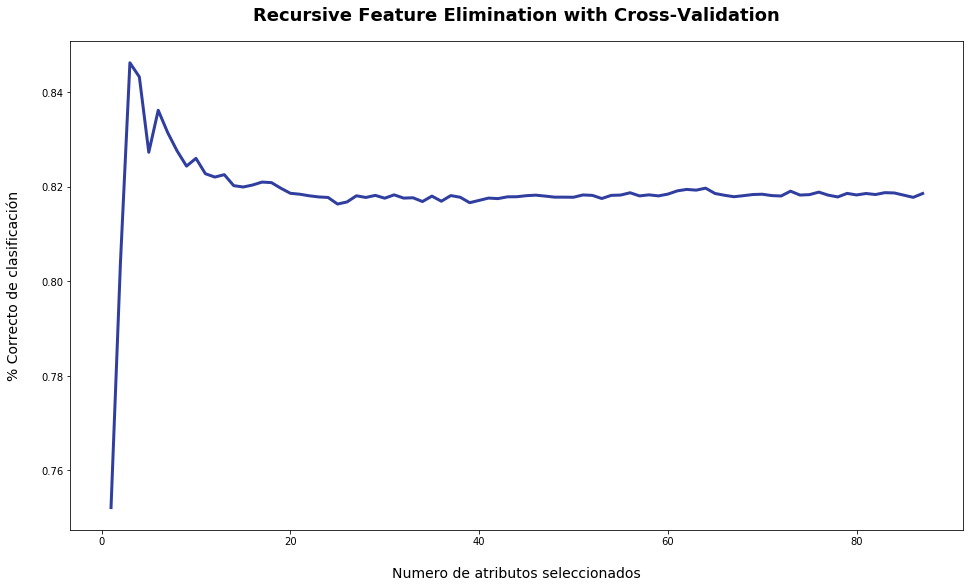

In [25]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Numero de atributos seleccionados', fontsize=14, labelpad=20)
plt.ylabel('% Correcto de clasificación', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [26]:
ClientesProcesadosRFE.drop(ClientesProcesadosRFE.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

<a id='RFEAtributos'></a>
### Muestra los atributos seleccionados por el proceso RFE de acuerdo a su importancia.

El algoritmo RFE selecciona 3 atributos, con estos se clasifica de forma correcta el 85% aproximadamente. Los atributos con mayor importancia de acuerdo al RFE son:

* Type_is_Married-civ-spouse
* AnosEducacion
* CapitalGanado



In [27]:
ClientesProcesadosRFE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 3 columns):
Type_is_Married-civ-spouse    45222 non-null uint8
AnosEducacion                 45222 non-null int64
CapitalGanado                 45222 non-null int64
dtypes: int64(2), uint8(1)
memory usage: 1.1 MB


<a id='Correlacion'></a>
## Matriz de correlación para el conjunto de datos. 

Se encuentra alta correlación entre los atributos Type_is_Husband y Type_is_Married-civ-spouse. Se procede eliminar el atributo Type_is_Husband.


In [28]:
corrMat = ClientesProcesados.corr () 
f = plt.figure(figsize=(150, 150))
plt.matshow(corrMat, fignum=f.number)
plt.xticks(range(ClientesProcesados.shape[1]), ClientesProcesados.columns, fontsize=60, rotation=90)
plt.yticks(range(ClientesProcesados.shape[1]), ClientesProcesados.columns, fontsize=60)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=50)

In [29]:
ClientesProcesadosCOR=ClientesProcesados.iloc[:,:] 
ClientesProcesadosCOR.drop("Type_is_Husband", axis=1, inplace=True)

<a id='Conjuntos'></a>
## Creación de los conjunto de datos de pruebas y entrenamiento con un porcentaje 75/25.

Se crean 4 conjuntos de datos distintos, con el objetivo de encontrar cual entrega la mejor precisión durante el entrenamiento del modelo.

* El primero conjunto con todos los atributos.
* El segundo conjunto mantiene los atributos sin correlación.
* El tercer conjunto contiene solo atributos seleccionados por su importancia con el método RFE.
* EL cuarto y último contiene los atributos seleccionados por su mayor varianza utilizando el método PCA.


In [45]:
x_train, x_test, y_train, y_test = train_test_split(ClientesProcesados, depVar)
x_trainCOR, x_testCOR, y_trainCOR, y_testCOR = train_test_split(ClientesProcesadosCOR, depVar)
x_trainRFE, x_testRFE, y_trainRFE, y_testRFE = train_test_split(ClientesProcesadosRFE, depVar)
x_trainPCA, x_testPCA, y_trainPCA, y_testPCA = train_test_split(ClientesProcesados, depVar)

<a id='PCA'></a>
## Elección de atributos con mayor variabilidad. 

Del total de 87 atributos se eligen 55 y estas representan el 77.40% de varianza de los datos.


In [31]:
sc = StandardScaler() 
x_trainPCA = sc.fit_transform(x_trainPCA) 
x_testPCA = sc.transform(x_testPCA) 
pca = PCA(n_components = 55) 
  
x_trainPCA = pca.fit_transform(x_trainPCA) 
x_testPCA = pca.transform(x_testPCA) 
  
explained_variance = pca.explained_variance_ratio_ 

In [32]:
sum(explained_variance)

0.7739469002014839

In [33]:
print(x_train.shape, x_test.shape, y_train.shape,y_test.shape)
print(x_trainCOR.shape, x_testCOR.shape, y_trainCOR.shape,y_testCOR.shape)
print(x_trainRFE.shape, x_testRFE.shape, y_trainRFE.shape,y_testRFE.shape)
print(x_trainPCA.shape, x_testPCA.shape, y_trainPCA.shape,y_testPCA.shape)

(33916, 86) (11306, 86) (33916,) (11306,)
(33916, 86) (11306, 86) (33916,) (11306,)
(33916, 3) (11306, 3) (33916,) (11306,)
(33916, 55) (11306, 55) (33916,) (11306,)


<a id='EntrenamientoEvaluacion'></a>
## Entrenamiento, evaluación y predicción 


<a id='Entrenamiento'></a>
### Entrenamiento y evaluación 

Para el entrenamiento y evaluación se eligen 6 métodos y cada uno de ellos será entranado con los 4 conjuntos de datos creados y se eligirá el apropiado para realizar ajuste y obtener la mayor precisión posible.

* KNeighborsClassifier
* SVC
* GaussianNB
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier

In [34]:
modelKN = KNeighborsClassifier()
modelSVC = SVC()
modelGNB = GaussianNB()
modelDT = DecisionTreeClassifier()
modelRF = RandomForestClassifier()
modelABC =  AdaBoostClassifier()


<a id='Metodo'></a>

### Método Entrenamiento.

Se crea un método "entrenaModelos", el cual recibe 3 parámetros: 
* El conjunto de datos X 
* El conjunto de datos Y
* Una lista anidada con los algoritmos que se desea entrenar, así como una etiqueta para cada uno.

El método imprimirá en consola la duración de entrenamiento en segundos y la precisión obtenida.

In [35]:
def entrenaModelos(conjuntoX,conjuntoY,algoritmos):
    precision=[]
    duracion=[]
    for algoritmo in algoritmos[0]:
        hora1 =time.time()
        algoritmo.fit(conjuntoX,conjuntoY)
        precision.append(round(algoritmo.score(conjuntoX,conjuntoY), 4))
        duracion.append(time.time()-hora1)
        
    algoritmos.append(precision)
    algoritmos.append(duracion)
    
    for i in range(len(duracion)):
        print('Algoritmo: ', algoritmos[1][i], ' Precisión: ', algoritmos[2][i], ' Duración Segundos: ',round(algoritmos[3][i],2))


<a id='Evaluacion'></a>

### Evaluación

Los resultados obtenidos luego de entrenar los modelos indican que los mejores resultados son entregados por los algoritmos Decision Tree y Random Forest, sin embargo una precisión tan alta nos puede señalar un sobre ajuste, por lo que se descartan por esta ocasión.

El algoritmo SVC en conjunto con el Gaussian brindan los resultados mas bajos, y el SVC los mayores duraciones por lo que ambos también se excluyen.

Finalmente KNeighbors y AdaBoost son los que tienen una buena precisión y bajos tiempos por lo que se decide realizar ajuste con ambos modelos utilizando el conjunto de datos en donde se eliminó los atributos que presentaban correlación.

<h2><center>El gráfico muestra los datos precisión y duración obtenidos</center></h2>
   
<img src="datos/grafico.png">


<h2><center>La tabla muestra los datos obtenidos</center></h2>

<img src="datos/tabla.png">

In [36]:
modelos=[[modelSVC,modelKN,modelGNB,modelDT,modelRF,modelABC],['SVC','KN','GNB','DT','RF','ABC']]
print('Entrenamiento con todos los atributos:')
entrenaModelos(x_train,y_train,modelos)
modelos=[[modelSVC,modelKN,modelGNB,modelDT,modelRF,modelABC],['SVC','KN','GNB','DT','RF','ABC']]
print('\nEntrenamiento eliminando correlación:')
entrenaModelos(x_trainCOR,y_trainCOR,modelos)
modelos=[[modelSVC,modelKN,modelGNB,modelDT,modelRF,modelABC],['SVC','KN','GNB','DT','RF','ABC']]
print('\nEntrenamiento selección atributos usando RFE:')
entrenaModelos(x_trainRFE,y_trainRFE,modelos)
modelos=[[modelSVC,modelKN,modelGNB,modelDT,modelRF,modelABC],['SVC','KN','GNB','DT','RF','ABC']]
print('\nEntrenamiento selección atributos usando PCA:')
entrenaModelos(x_trainPCA,y_trainPCA,modelos)


Entrenamiento con todos los atributos:
Algoritmo:  SVC  Precisión:  0.7951  Duración Segundos:  128.42
Algoritmo:  KN  Precisión:  0.8908  Duración Segundos:  27.89
Algoritmo:  GNB  Precisión:  0.8064  Duración Segundos:  0.39
Algoritmo:  DT  Precisión:  0.9738  Duración Segundos:  0.72
Algoritmo:  RF  Precisión:  0.9738  Duración Segundos:  7.26
Algoritmo:  ABC  Precisión:  0.8575  Duración Segundos:  6.63

Entrenamiento eliminando correlación:
Algoritmo:  SVC  Precisión:  0.7971  Duración Segundos:  140.91
Algoritmo:  KN  Precisión:  0.8907  Duración Segundos:  29.73
Algoritmo:  GNB  Precisión:  0.8078  Duración Segundos:  0.31
Algoritmo:  DT  Precisión:  0.9739  Duración Segundos:  0.73
Algoritmo:  RF  Precisión:  0.9739  Duración Segundos:  6.81
Algoritmo:  ABC  Precisión:  0.8592  Duración Segundos:  5.15

Entrenamiento selección atributos usando RFE:
Algoritmo:  SVC  Precisión:  0.7951  Duración Segundos:  22.94
Algoritmo:  KN  Precisión:  0.8293  Duración Segundos:  3.49
Algorit

<a id='Ajuste'></a>

### Ajuste de parámetros

Inicialmente se realizan varios ajustes sobre el algoritmo KNeighbors llegando a un sobre ajuste y sin embargo la mejor precisión obtenida posterior a la predicción es de un 84.89%. Los parámetros finales quedan de la siguiente forma: 

* n_neighbors=10
* weights='distance'
* algorithm='brute'
* p = 1
* n_jobs=2

Por otra parte se realiza ajuste del algoritmo AdaBoost y se logra una precisión de un 86.95% posterior a la predicción, considerando como fiable la predicción que este algoritmo realiza. Los parámetros finales se ajustan de la siguiente forma:

* n_estimators=2700
* learning_rate=1.2




In [37]:
modelKN = KNeighborsClassifier(n_neighbors=10,weights='distance',algorithm='brute',p = 1,n_jobs=2) #algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
modelKN.fit(x_trainCOR,y_trainCOR)
print(round(modelKN.score(x_trainCOR,y_trainCOR), 4) )
KN_predictionCOR = modelKN.predict(x_testCOR)
print(accuracy_score(KN_predictionCOR, y_testCOR))
print(confusion_matrix(KN_predictionCOR, y_testCOR))
print(classification_report(KN_predictionCOR, y_testCOR))

0.9737
0.8483106315230851
[[7762  991]
 [ 724 1829]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      8753
           1       0.65      0.72      0.68      2553

    accuracy                           0.85     11306
   macro avg       0.78      0.80      0.79     11306
weighted avg       0.85      0.85      0.85     11306



In [46]:

modelABC = AdaBoostClassifier(n_estimators=2700,learning_rate=1.2) 
modelABC.fit(x_trainCOR,y_trainCOR)
print(round(modelABC.score(x_trainCOR,y_trainCOR), 4) )
ABC_predictionCOR = modelABC.predict(x_testCOR)
print(accuracy_score(ABC_predictionCOR, y_testCOR))
print(confusion_matrix(ABC_predictionCOR, y_testCOR))
print(classification_report(ABC_predictionCOR, y_testCOR))

0.8705
0.8690960551919334
[[7986  974]
 [ 506 1840]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.92      8960
           1       0.65      0.78      0.71      2346

    accuracy                           0.87     11306
   macro avg       0.80      0.84      0.81     11306
weighted avg       0.88      0.87      0.87     11306



<a id='Matriz'></a>

### Matriz de confusión

La matriz de confusión nos indica que de 8984 valores menores o iguales (0) a los $50,000.00 se predijeron correctamente 8000 valores y de forma incorrecta 984.

Para el caso de los valores mayores (1) a $50,000.00 se predijeron correctamente 1831 valores y de forma incorrecta 491.



In [47]:
cf=confusion_matrix(ABC_predictionCOR, y_testCOR)

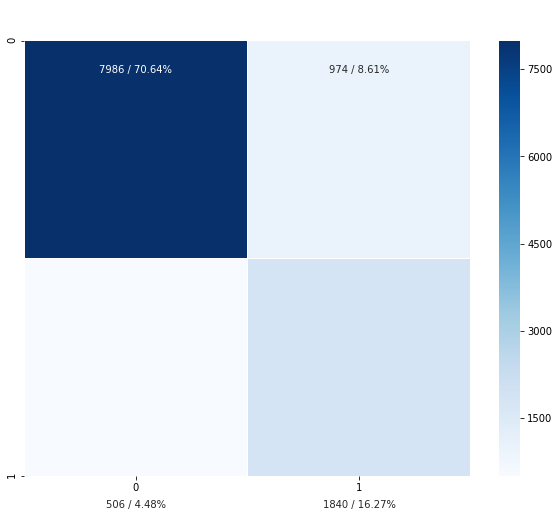

In [48]:

group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"\n\n\n\n\n{v2} / {v3}" for v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (10,8))
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues',linewidths=0.5)